# Superradiance in the open Dicke model: $N$ qubits in a bosonic cavity 

Author: Nathan Shammah (nathan.shammah@gmail.com)

We consider a system of $N$ two-level systems (TLSs) coupled to a cavity mode. This is known as the Dicke model 

\begin{eqnarray*}
H &=&\omega_{0}J_z +  \omega_{c}a^\dagger a + g\left(a^\dagger + a\right)\left(J_{+} + J_{-}\right)
\end{eqnarray*}

where each TLS has identical frequency $\omega_{0}$. The light matter coupling can be in the ultrastrong coupling (USC) regime, $g/\omega_{0}>0.1$.

If we study this model as an open quantum system, the cavity can leak photons and the TLSs are subject to local processes. For example the system can be incoherently pumped at a rate $\gamma_\text{P}$, the TLSs are subject to dephaisng at a rate $\gamma_\text{D}$, and local incoherent emission occurs at a rate $\gamma_\text{E}$. The dynamics of the coupled light-matter system is governed by

\begin{eqnarray}
\dot{\rho} &=& 
-i\lbrack \omega_{0}J_z +  \omega_{a}a^\dagger a + g\left(a^\dagger + a\right)\left(J_{+} + J_{-}\right),\rho \rbrack
+\frac{\kappa}{2}\mathcal{L}_{a}[\rho]
+\sum_{n=1}^{N}\left(\frac{\gamma_\text{P}}{2}\mathcal{L}_{J_{+,n}}[\rho] 
+\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{+,n}}[\rho]
+\frac{\gamma_\text{D}}{2}\mathcal{L}_{J_{+,n}}[\rho]\right)
\end{eqnarray}

When only the dissipation of the cavity is present, beyond a critical value of the coupling $g$, the steady state of the system becomes superradiant. This is visible by looking at the Wigner function of the photonic part of the density matrix, which displays two displaced lobes in the $x$ and $p$ plane.   

As it has been shown in Ref. [1], the presence of dephasing suppresses the superradiant phase transition, while the presence of local emission restores it [2].

In order to study this system using QuTiP and $PIQS$, we will first build the TLS Liouvillian, then we will build the photonic Liouvillian and finally we will build the light-matter interaction. The total dynamics of the system is thus defined in a Liouvillian space that has both TLS and photonic degrees of freedom. 

This is driven-dissipative system dysplaying out-of-equilibrium quantum phase transition.

In [1]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

from qutip import *
from qutip.piqs import *

In [2]:
#TLS parameters
N = 6
ntls = N
nds = num_dicke_states(ntls)
[jx, jy, jz] = jspin(N)
jp = jspin(N,"+")
jm = jp.dag()
w0 = 1
gE = 0.1
gD = 0.01
h = w0 * jz
#photonic parameters
nphot = 20
wc = 1
kappa = 1
ratio_g = 2
g = ratio_g/np.sqrt(N)
a = destroy(nphot)

In [3]:
#TLS liouvillian
system = Dicke(N = N)
system.hamiltonian = h 
system.emission = gE 
system.dephasing = gD
liouv = system.liouvillian() 

#photonic liouvilian
h_phot = wc * a.dag() * a
c_ops_phot = [np.sqrt(kappa) * a]
liouv_phot = liouvillian(h_phot, c_ops_phot)

#identity operators
id_tls = to_super(qeye(nds))
id_phot = to_super(qeye(nphot))

#light-matter superoperator and total liouvillian
liouv_sum = super_tensor(liouv_phot, id_tls) + super_tensor(id_phot, liouv)
h_int = g * tensor(a + a.dag(), jx)
liouv_int = -1j* spre(h_int) + 1j* spost(h_int)
liouv_tot = liouv_sum + liouv_int

In [4]:
#total operators
jz_tot = tensor(qeye(nphot), jz)
jpjm_tot = tensor(qeye(nphot), jp*jm)
nphot_tot = tensor(a.dag()*a, qeye(nds))

In [5]:
rho_ss = steadystate(liouv_tot, method="eigen")
jz_ss = expect(jz_tot, rho_ss)
jpjm_ss = expect(jpjm_tot, rho_ss)
nphot_ss = expect(nphot_tot, rho_ss)
psi = rho_ss.ptrace(0)
xvec = np.linspace(-6, 6, 100)
W = wigner(psi, xvec, xvec)

## Wigner Function
Below we calculate the Wigner function of the photonic part of the steady state. It shows two displaced squeezed states in the reciprocal photonic space. The result is in agreement with the findings of Ref [2].

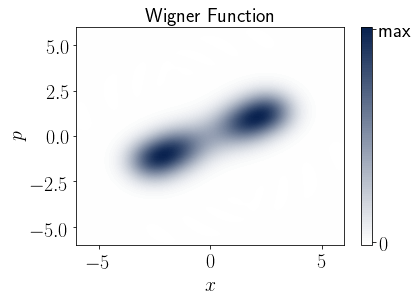

In [6]:
jmax = (0.5 * N)
j2max = (0.5 * N + 1) * (0.5 * N)

plt.rc('text', usetex = True)
label_size = 20
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

wmap = wigner_cmap(W)  # Generate Wigner colormap
nrm = mpl.colors.Normalize(0, W.max())
max_cb =np.max(W)
min_cb =np.min(W)

fig2 = plt.figure(2)
plotw = plt.contourf(xvec, xvec, W, 100, cmap=wmap, norm=nrm)
plt.title(r"Wigner Function", fontsize=label_size);
plt.xlabel(r'$x$', fontsize = label_size)
plt.ylabel(r'$p$', fontsize = label_size)
cb = plt.colorbar()
cb.set_ticks( [min_cb, max_cb])
cb.set_ticklabels([r'$0$',r'max'])    

plt.show()
plt.close()

## Time Evolution

Here we calculate the time evolution of a state initialized in the most excited spin state with no photons in the cavity. We calculate the full density matrix evolution as well as spin and photon operator mean values.  

In [7]:
#set initial conditions for spins and cavity
tmax = 40
nt = 1000
t = np.linspace(0, tmax, nt)
rho0 = dicke(N, N/2, N/2)
rho0_phot = ket2dm(basis(nphot,0))
rho0_tot = tensor(rho0_phot, rho0)
result = mesolve(liouv_tot, rho0_tot, t, [], e_ops = [jz_tot, jpjm_tot, nphot_tot])
rhot_tot = result.states
jzt_tot = result.expect[0]
jpjmt_tot = result.expect[1]
adagat_tot = result.expect[2]

## Plots

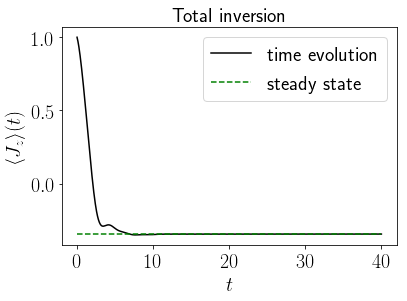

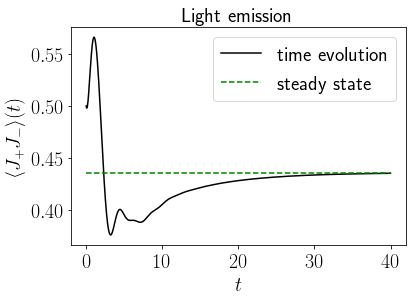

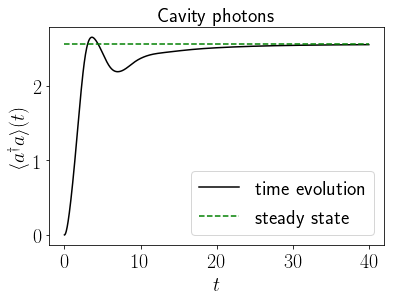

In [8]:
jmax = (N/2)
j2max = N/2*(N/2+1)

fig1 = plt.figure(1)
plt.plot(t, jzt_tot/jmax, 'k-', label='time evolution')
plt.plot(t, t*0+jz_ss/jmax, 'g--', label='steady state')
plt.title('Total inversion', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
plt.ylabel(r'$\langle J_z\rangle (t)$', fontsize = label_size)
plt.legend(fontsize = label_size)
plt.show()
plt.close()

fig2 = plt.figure(2)
plt.plot(t, jpjmt_tot/j2max, 'k-', label='time evolution')
plt.plot(t, t*0+jpjm_ss/j2max, 'g--', label='steady state')
plt.xlabel(r'$t$', fontsize = label_size)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle (t)$', fontsize = label_size)
plt.title('Light emission', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
plt.legend(fontsize = label_size)
plt.show()
plt.close()

fig3 = plt.figure(3)
plt.plot(t, adagat_tot, 'k-', label='time evolution')
plt.plot(t, t*0 + nphot_ss, 'g--', label='steady state')
plt.title('Cavity photons', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size)
plt.ylabel(r'$\langle a^\dagger a \rangle (t)$', fontsize = label_size)

plt.legend(fontsize = label_size)
plt.show()
plt.close()

## References

[1] E.G. Dalla Torre *et al.*, *Phys Rev. A* **94**, 061802(R) (2016)

[2] P. Kirton and J. Keeling, , *Phys. Rev. Lett.* **118**, 123602 (2017)

[3] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, *to be submitted*.

[4] J. R. Johansson, P. D. Nation, and F. Nori, *Comp. Phys. Comm.* **183**, 1760 (2012). http://qutip.org


In [9]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.1
Numpy Version:      1.14.2
Scipy Version:      1.1.0
Cython Version:     0.28.5
Matplotlib Version: 2.2.3
Python Version:     3.6.7
Number of CPUs:     2
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/nathanshammah/miniconda3/lib/python3.6/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.cite()`
